In [16]:
# Basis-Bibliotheken für Datenverarbeitung
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy   
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Transformer für Sentiment-Analyse
from transformers import pipeline

print("Setup abgeschlossen!")
print(f"Pandas Version: {pd.__version__}")
print(f"NumPy Version: {np.__version__}")


Setup abgeschlossen!
Pandas Version: 2.3.0+4.g1dfc98e16a
NumPy Version: 2.0.2


In [17]:
# Tweets laden
print("Lade Tweet-Daten...")
tweets_df = pd.read_csv('stock_tweets.csv')
print(f"Tweet-Datensatz: {tweets_df.shape[0]} Zeilen, {tweets_df.shape[1]} Spalten")

# Aktienkurse laden
print("Lade Aktienkurs-Daten...")
stock_df = pd.read_csv('stock_yfinance_data.csv')
print(f"Aktienkurs-Datensatz: {stock_df.shape[0]} Zeilen, {stock_df.shape[1]} Spalten")

# Erste Einblicke
print("\n=== Tweet-Daten ===")
print(tweets_df.head())
print("\nVerfügbare Aktien in Tweets:", tweets_df['Stock Name'].unique())

print("\n=== Aktienkurs-Daten ===")
print(stock_df.head())
print("\nVerfügbare Aktien in Kursdaten:", stock_df['Stock Name'].unique())


Lade Tweet-Daten...
Tweet-Datensatz: 80793 Zeilen, 4 Spalten
Lade Aktienkurs-Daten...
Aktienkurs-Datensatz: 6300 Zeilen, 8 Spalten

=== Tweet-Daten ===
                        Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.  

Verfügbare Aktien in Tweets: ['TSLA' 'MSFT' 'PG' 'META' 'AMZN' 'GOOG' 'AMD' 'AAPL' 'NFLX' 'TSM' 'KO'
 'F' 'COST' 'DIS' 'VZ' 'CRM' 'INTC' 'BA' 'BX' 'NOC' 'PYPL' 'ENPH' 'NIO'
 'ZS' '

In [18]:
# Datum-Spalten konvertieren
print("Konvertiere Datumsangaben...")

# Tweets: Datum konvertieren und nur das Datum (ohne Uhrzeit) extrahieren
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'], errors='coerce')
tweets_df['Date_only'] = tweets_df['Date'].dt.date

# Aktienkurse: Datum konvertieren
stock_df['Date'] = pd.to_datetime(stock_df['Date'], errors='coerce')
stock_df['Date_only'] = stock_df['Date'].dt.date

# Fehlende Werte entfernen
tweets_df.dropna(subset=['Date', 'Tweet', 'Stock Name'], inplace=True)
stock_df.dropna(subset=['Date', 'Close', 'Stock Name'], inplace=True)

print(f"Nach Bereinigung - Tweets: {tweets_df.shape[0]} Zeilen")
print(f"Nach Bereinigung - Aktienkurse: {stock_df.shape[0]} Zeilen")

# Zeitraum der Daten anzeigen
print(f"\nTweets Zeitraum: {tweets_df['Date'].min()} bis {tweets_df['Date'].max()}")
print(f"Aktienkurse Zeitraum: {stock_df['Date'].min()} bis {stock_df['Date'].max()}")


Konvertiere Datumsangaben...
Nach Bereinigung - Tweets: 80793 Zeilen
Nach Bereinigung - Aktienkurse: 6300 Zeilen

Tweets Zeitraum: 2021-09-30 00:06:02+00:00 bis 2022-09-29 23:41:16+00:00
Aktienkurse Zeitraum: 2021-09-30 00:00:00 bis 2022-09-29 00:00:00


Führe Sentiment-Analyse durch...
Sentiment-Analyse abgeschlossen!
Durchschnittlicher Sentiment-Score: 0.1760
Sentiment-Score Bereich: -0.9911 bis 0.9925


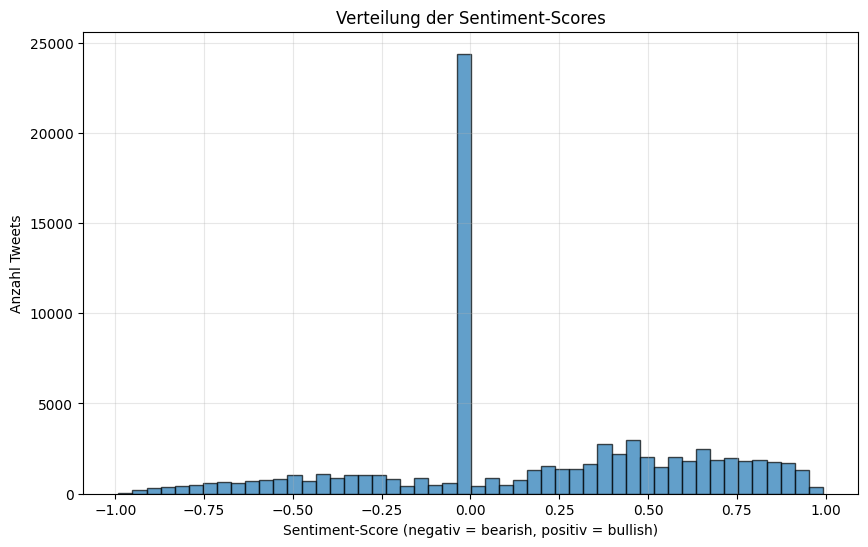

In [19]:
# Für die Demo verwenden wir VADER (schneller als Transformer)
# In der Produktion würden Sie FinBERT oder ähnliche Transformer verwenden
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# VADER Lexikon herunterladen
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except nltk.downloader.DownloadError:
    nltk.download('vader_lexicon')

# Sentiment Analyzer initialisieren
vader = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    """
    Analysiert das Sentiment eines Textes mit VADER
    Gibt compound score zurück (-1 bis +1)
    """
    try:
        scores = vader.polarity_scores(str(text))
        return scores['compound']
    except:
        return 0.0

# Sentiment-Analyse auf Tweets anwenden
print("Führe Sentiment-Analyse durch...")
tweets_df['sentiment_score'] = tweets_df['Tweet'].apply(analyze_sentiment)

print(f"Sentiment-Analyse abgeschlossen!")
print(f"Durchschnittlicher Sentiment-Score: {tweets_df['sentiment_score'].mean():.4f}")
print(f"Sentiment-Score Bereich: {tweets_df['sentiment_score'].min():.4f} bis {tweets_df['sentiment_score'].max():.4f}")

# Verteilung visualisieren
plt.figure(figsize=(10, 6))
plt.hist(tweets_df['sentiment_score'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Verteilung der Sentiment-Scores')
plt.xlabel('Sentiment-Score (negativ = bearish, positiv = bullish)')
plt.ylabel('Anzahl Tweets')
plt.grid(True, alpha=0.3)
plt.show()


In [20]:
# Technische Indikatoren für jede Aktie berechnen
def calculate_technical_indicators(df):
    """
    Berechnet technische Indikatoren für einen DataFrame mit Aktienkursen
    """
    df = df.copy()
    df = df.sort_values('Date').reset_index(drop=True)
    
    # RSI (Relative Strength Index)
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.rolling(window=window, min_periods=window).mean()
        avg_loss = loss.rolling(window=window, min_periods=window).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    # Moving Averages
    df['MA_5'] = df['Close'].rolling(window=5).mean()
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    
    # RSI
    df['RSI'] = calculate_rsi(df['Close'])
    
    # Bollinger Bands
    df['BB_middle'] = df['Close'].rolling(window=20).mean()
    df['BB_std'] = df['Close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + (df['BB_std'] * 2)
    df['BB_lower'] = df['BB_middle'] - (df['BB_std'] * 2)
    
    # Price relative to Bollinger Bands
    df['BB_position'] = (df['Close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])
    
    # Volume indicators
    df['Volume_MA'] = df['Volume'].rolling(window=20).mean()
    df['Volume_ratio'] = df['Volume'] / df['Volume_MA']
    
    # Price change indicators
    df['Price_change'] = df['Close'].pct_change()
    df['Price_change_5d'] = df['Close'].pct_change(periods=5)
    
    return df

# Technische Indikatoren für jede Aktie berechnen
print("Berechne technische Indikatoren...")
stock_with_indicators = []

for stock in stock_df['Stock Name'].unique():
    stock_data = stock_df[stock_df['Stock Name'] == stock].copy()
    stock_data_with_indicators = calculate_technical_indicators(stock_data)
    stock_with_indicators.append(stock_data_with_indicators)

# Alle Aktien wieder zusammenfügen
stock_df_enhanced = pd.concat(stock_with_indicators, ignore_index=True)

print(f"Technische Indikatoren berechnet für {stock_df_enhanced['Stock Name'].nunique()} Aktien")
print(f"Neue Spalten: {[col for col in stock_df_enhanced.columns if col not in stock_df.columns]}")

# Erste Zeilen mit Indikatoren anzeigen
print("\nErste Zeilen mit technischen Indikatoren:")
print(stock_df_enhanced[['Date', 'Stock Name', 'Close', 'RSI', 'MA_5', 'MA_20', 'BB_position']].head(10))


Berechne technische Indikatoren...
Technische Indikatoren berechnet für 25 Aktien
Neue Spalten: ['MA_5', 'MA_20', 'RSI', 'BB_middle', 'BB_std', 'BB_upper', 'BB_lower', 'BB_position', 'Volume_MA', 'Volume_ratio', 'Price_change', 'Price_change_5d']

Erste Zeilen mit technischen Indikatoren:
        Date Stock Name       Close  RSI        MA_5  MA_20  BB_position
0 2021-09-30       TSLA  258.493347  NaN         NaN    NaN          NaN
1 2021-10-01       TSLA  258.406677  NaN         NaN    NaN          NaN
2 2021-10-04       TSLA  260.510010  NaN         NaN    NaN          NaN
3 2021-10-05       TSLA  260.196655  NaN         NaN    NaN          NaN
4 2021-10-06       TSLA  260.916656  NaN  259.704669    NaN          NaN
5 2021-10-07       TSLA  264.536682  NaN  260.913336    NaN          NaN
6 2021-10-08       TSLA  261.829987  NaN  261.597998    NaN          NaN
7 2021-10-11       TSLA  263.980011  NaN  262.291998    NaN          NaN
8 2021-10-12       TSLA  268.573334  NaN  263.967334 

In [22]:
# Tweet-Sentiment pro Tag und Aktie aggregieren
print("Aggregiere Tweet-Sentiment-Daten...")

# Tweets pro Tag und Aktie zusammenfassen
tweet_daily = tweets_df.groupby(['Date_only', 'Stock Name']).agg({
    'sentiment_score': ['mean', 'std', 'count'],
    'Tweet': 'count'
}).reset_index()

# Spalten umbenennen
tweet_daily.columns = ['Date_only', 'Stock Name', 'sentiment_mean', 'sentiment_std', 'sentiment_count', 'tweet_count']

# NaN-Werte für Standardabweichung durch 0 ersetzen (wenn nur ein Tweet pro Tag)
tweet_daily['sentiment_std'] = tweet_daily['sentiment_std'].fillna(0)

print(f"Tweet-Daten aggregiert: {tweet_daily.shape[0]} Zeilen")
print("Erste Zeilen der aggregierten Tweet-Daten:")
print(tweet_daily.head())

# Aktienkurs-Daten mit Ziel-Variable erweitern
print("\nErstelle Ziel-Variable (nächster Tag steigt/fällt)...")

# Für jede Aktie die Ziel-Variable berechnen
stock_with_target = []

for stock in stock_df_enhanced['Stock Name'].unique():
    stock_data = stock_df_enhanced[stock_df_enhanced['Stock Name'] == stock].copy()
    stock_data = stock_data.sort_values('Date').reset_index(drop=True)
    
    # Ziel-Variable: Steigt der Kurs am nächsten Tag?
    stock_data['next_day_close'] = stock_data['Close'].shift(-1)
    stock_data['price_up_tomorrow'] = (stock_data['next_day_close'] > stock_data['Close']).astype(int)
    
    stock_with_target.append(stock_data)

stock_df_final = pd.concat(stock_with_target, ignore_index=True)

# Letzte Zeile entfernen (kein nächster Tag verfügbar)
stock_df_final = stock_df_final.dropna(subset=['next_day_close'])

print(f"Aktienkurs-Daten mit Ziel-Variable: {stock_df_final.shape[0]} Zeilen")
print(f"Verteilung Ziel-Variable: {stock_df_final['price_up_tomorrow'].value_counts()}")

# Daten zusammenführen
print("\nFühre Tweet- und Aktienkurs-Daten zusammen...")

# Merge auf Datum und Aktie
final_df = pd.merge(
    stock_df_final,
    tweet_daily,
    on=['Date_only', 'Stock Name'],
    how='left'
)

print(f"Zusammengeführter Datensatz: {final_df.shape[0]} Zeilen, {final_df.shape[1]} Spalten")

# Fehlende Tweet-Daten mit 0 füllen (Tage ohne Tweets)
sentiment_cols = ['sentiment_mean', 'sentiment_std', 'sentiment_count', 'tweet_count']
final_df[sentiment_cols] = final_df[sentiment_cols].fillna(0)

print(f"Nach Auffüllen fehlender Werte: {final_df.shape[0]} Zeilen")
print("\nErste Zeilen des finalen Datensatzes:")
print(final_df[['Date', 'Stock Name', 'Close', 'RSI', 'sentiment_mean', 'tweet_count', 'price_up_tomorrow']].head())


Aggregiere Tweet-Sentiment-Daten...
Tweet-Daten aggregiert: 5910 Zeilen
Erste Zeilen der aggregierten Tweet-Daten:
    Date_only Stock Name  sentiment_mean  sentiment_std  sentiment_count  \
0  2021-09-30       AAPL         0.09890       0.319659                7   
1  2021-09-30        AMD         0.41780       0.422632                6   
2  2021-09-30       AMZN         0.24648       0.597336                5   
3  2021-09-30        DIS         0.54610       0.000000                1   
4  2021-09-30       GOOG         0.44040       0.000000                1   

   tweet_count  
0            7  
1            6  
2            5  
3            1  
4            1  

Erstelle Ziel-Variable (nächster Tag steigt/fällt)...
Aktienkurs-Daten mit Ziel-Variable: 6275 Zeilen
Verteilung Ziel-Variable: price_up_tomorrow
0    3251
1    3024
Name: count, dtype: int64

Führe Tweet- und Aktienkurs-Daten zusammen...
Zusammengeführter Datensatz: 6275 Zeilen, 27 Spalten
Nach Auffüllen fehlender Werte: 6

In [23]:
#
# ZELLE 14: LSTM MODELL
#
print("Bereite Daten für LSTM-Modell vor...")




# Feature-Spalten definieren
feature_columns = [
    'RSI', 'MA_5', 'MA_20', 'BB_position', 'Volume_ratio',
    'Price_change', 'Price_change_5d',
    'sentiment_mean', 'tweet_count'
]

# Nur Zeilen mit allen Features verwenden (keine NaN-Werte)
ml_df = final_df.dropna(subset=feature_columns + ['price_up_tomorrow'])

print(f"Datensatz für ML: {ml_df.shape[0]} Zeilen")

# Features und Ziel-Variable extrahieren
X_full = ml_df[feature_columns].values
y_full = ml_df['price_up_tomorrow'].values

# Daten skalieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

# Daten in Sequenzen für LSTM umwandeln
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10  # Eine Sequenz von 10 Tagen verwenden, um den 11. vorherzusagen
X_seq, y_seq = create_sequences(X_scaled, y_full, TIME_STEPS)

print(f"Form der LSTM-Sequenzen (X): {X_seq.shape}") # (Samples, Timesteps, Features)
print(f"Form der Ziel-Variable (y): {y_seq.shape}")

# Zeitlich korrekter Train/Test-Split
split_idx = int(len(X_seq) * 0.8)

X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

print(f"\nTrainingsdaten: {X_train.shape[0]} Sequenzen")
print(f"Testdaten: {X_test.shape[0]} Sequenzen")

# LSTM-Modell erstellen
print("\nErstelle LSTM-Modell...")
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1, activation='sigmoid') # Sigmoid für binäre Klassifikation
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Modell trainieren
print("\nTrainiere LSTM-Modell...")
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1, # 10% der Trainingsdaten für die Validierung während des Trainings verwenden
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

Bereite Daten für LSTM-Modell vor...
Datensatz für ML: 5800 Zeilen
Form der LSTM-Sequenzen (X): (5790, 10, 10)
Form der Ziel-Variable (y): (5790,)

Trainingsdaten: 4632 Sequenzen
Testdaten: 1158 Sequenzen

Erstelle LSTM-Modell...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,701 (131.64 KB)

 Trainable params: 33,701 (131.64 KB)

 Non-trainable params: 0 (0.00 B)


Trainiere LSTM-Modell...
Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5048 - loss: 0.6943 - val_accuracy: 0.5151 - val_loss: 0.6919
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5331 - loss: 0.6889 - val_accuracy: 0.5151 - val_loss: 0.6994
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5290 - loss: 0.6920 - val_accuracy: 0.5237 - val_loss: 0.6945
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5239 - loss: 0.6910 - val_accuracy: 0.5237 - val_loss: 0.6904
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5299 - loss: 0.6883 - val_accuracy: 0.5259 - val_loss: 0.6994
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5521 - loss: 0.6861 - val_accuracy: 0.5259 - val_loss: 0.6920
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5439 - loss: 0.6893 - val_accuracy: 0.5366 - val_loss: 0.6929


Evaluiere LSTM-Modell...

Modell-Genauigkeit auf Testdaten: 0.5380


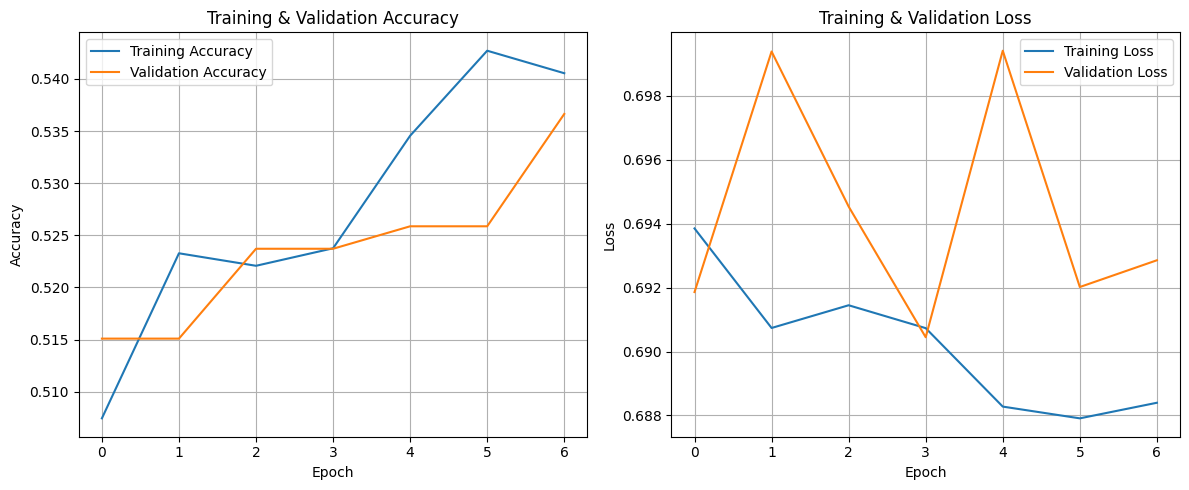

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Detaillierter Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.54      0.85      0.66       615
           1       0.52      0.18      0.27       543

    accuracy                           0.54      1158
   macro avg       0.53      0.52      0.47      1158
weighted avg       0.53      0.54      0.48      1158



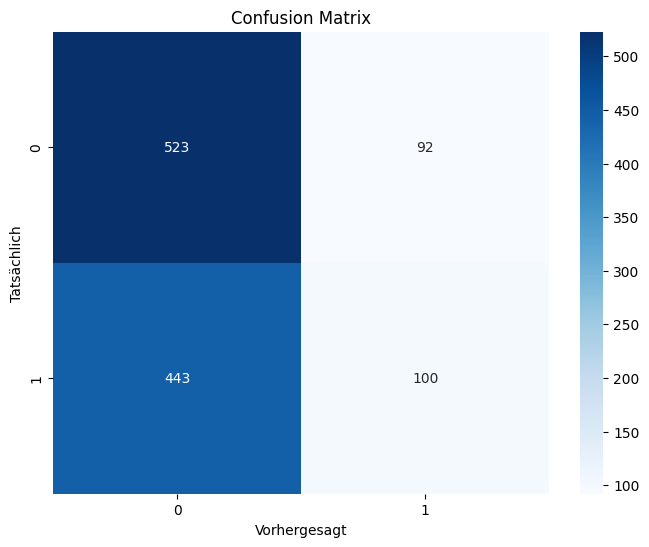

In [24]:
#
# ZELLE 16: LSTM EVALUATION
#
print("Evaluiere LSTM-Modell...")

# Modell-Performance auf Testdaten evaluieren
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nModell-Genauigkeit auf Testdaten: {accuracy:.4f}")

# Trainingsverlauf visualisieren
plt.figure(figsize=(12, 5))

# Plot für Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot für Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Vorhersagen machen
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

# Detaillierter Klassifikationsbericht
print("\nDetaillierter Klassifikationsbericht:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Vorhergesagt')
plt.ylabel('Tatsächlich')
plt.show()